<a href="https://colab.research.google.com/github/lazarussim12-beep/DLI_GRP_Assignment/blob/Lazarus-Sim/Lazarus%20Sim%20Wen%20Hui's%20Code%20only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import all required library


In [4]:
import os
import re
import time
import zipfile
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from typing import Tuple

import xgboost as xgb
import lightgbm as lgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout,
    LSTM,
    Bidirectional,
    Input,
    GRU,
)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import joblib

from sklearn.utils.validation import check_is_fitted
from tabulate import tabulate



# Import Dataset

--2025-08-23 09:05:34--  https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip [following]
--2025-08-23 09:05:34--  https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip.1’

enron_spam_data.zip 100%

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14



Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

=== SPAM vs HAM Analysis ===
Using column: 'Spam/Ham'
Counts by category:
Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages by category:
spam: 50.93%
ham: 49.07%

Detailed Analysis:
Total emails: 33716
ham: 16545 emails (49.07%)
spam: 17171 emails (50.93%)


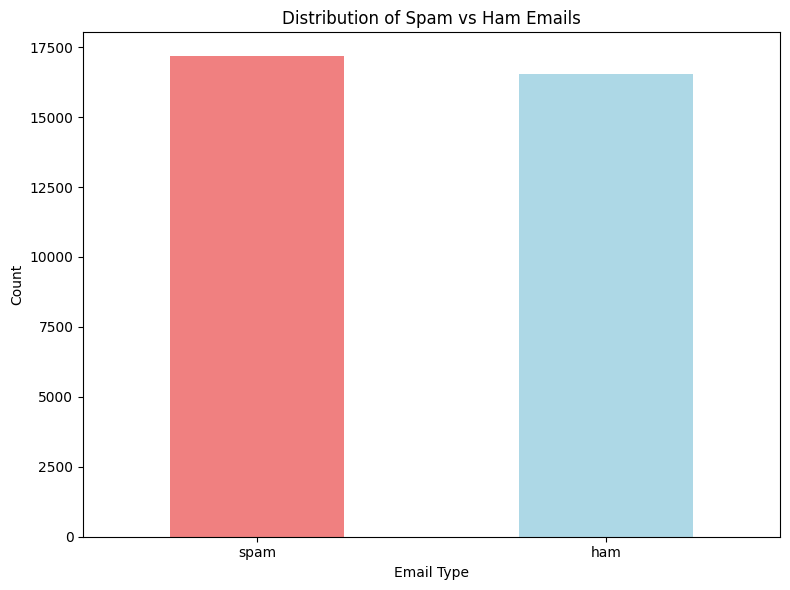

In [5]:
# Download the zip file from GitHub
!wget https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip

# Unzip the file
import zipfile
with zipfile.ZipFile('enron_spam_data.zip', 'r') as zip_ref:
    zip_ref.extractall('enron_data')

# List extracted files
import os
extracted_files = os.listdir('enron_data')
print("Extracted files:", extracted_files)

# Load the CSV file(s) into pandas
import pandas as pd

for file in extracted_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'enron_data/{file}')
        print(f"Loaded {file} with shape:", df.shape)

        # Display first few rows
        display(df.head())

        print(f"\nColumn names: {df.columns.tolist()}")

        # Calculate number of spam and ham in the Spam/Ham column
        print("\n=== SPAM vs HAM Analysis ===")

        spam_col = None
        for col in df.columns:
            if 'spam' in col.lower() or 'ham' in col.lower():
                spam_col = col
                break

        if spam_col is None:
            spam_col = df.columns[3] if len(df.columns) > 3 else df.columns[-1]

        print(f"Using column: '{spam_col}'")

        # Count values in the spam/ham column
        spam_ham_counts = df[spam_col].value_counts()
        print("Counts by category:")
        print(spam_ham_counts)

        # Calculate percentages
        spam_ham_percentages = df[spam_col].value_counts(normalize=True) * 100
        print("==========================")
        print("\nPercentages by category:")
        for category, percentage in spam_ham_percentages.items():
            print(f"{category}: {percentage:.2f}%")

        # More detailed analysis
        total_emails = len(df)
        print("==========================")
        print(f"\nDetailed Analysis:")
        print(f"Total emails: {total_emails}")

        for category in df[spam_col].unique():
            count = (df[spam_col] == category).sum()
            percentage = (count / total_emails) * 100
            print(f"{category}: {count} emails ({percentage:.2f}%)")

        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(8, 6))
            spam_ham_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
            plt.title('Distribution of Spam vs Ham Emails')
            plt.xlabel('Email Type')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nMatplotlib not available for visualization")

        break

# Lazarus Sim Wen Hui Code

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


759/759 - 11s - 14ms/step - accuracy: 0.9257 - loss: 0.1683 - val_accuracy: 0.9778 - val_loss: 0.0625
Epoch 2/5
759/759 - 3s - 4ms/step - accuracy: 0.9848 - loss: 0.0457 - val_accuracy: 0.9778 - val_loss: 0.0556
Epoch 3/5
759/759 - 5s - 6ms/step - accuracy: 0.9912 - loss: 0.0260 - val_accuracy: 0.9800 - val_loss: 0.0628
Epoch 4/5
759/759 - 3s - 3ms/step - accuracy: 0.9943 - loss: 0.0176 - val_accuracy: 0.9792 - val_loss: 0.0801
Epoch 5/5
759/759 - 3s - 3ms/step - accuracy: 0.9949 - loss: 0.0164 - val_accuracy: 0.9781 - val_loss: 0.0783


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:06:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.441310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917311
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL EVALUATION TABLE (THRESH=0.5): Accuracy, Precision, Recall, F1, ROC-AUC, Params/Size, Inference time (ms)
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------+
| Model                              |   Acc |   Prec |   Rec |    F1 |   AUC | Size/Params               |   Inference (ms) |
+====================================+=======+========+=======+=======+=======+===========================+==================+
| Logistic Regression (TF-IDF)       | 0.986 |  0.979 | 0.994 | 0.986 | 0.998 | params=10,001             |            2.160 |
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------+
| Logistic Regression (CNN-features) | 0.980 |  0.974 | 0.988 | 0.981 | 0.998 | params=65                 |            1.010 |
+------------------------------------+-------+--------+-------+-------+-------+---------------------------+------------------

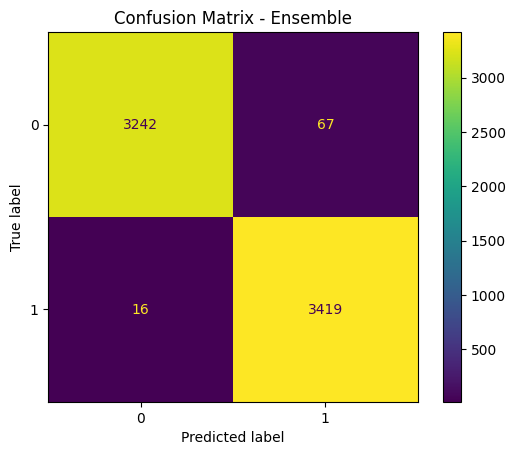

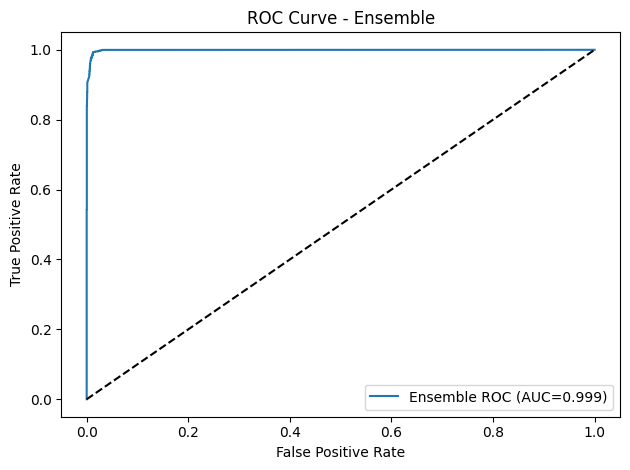

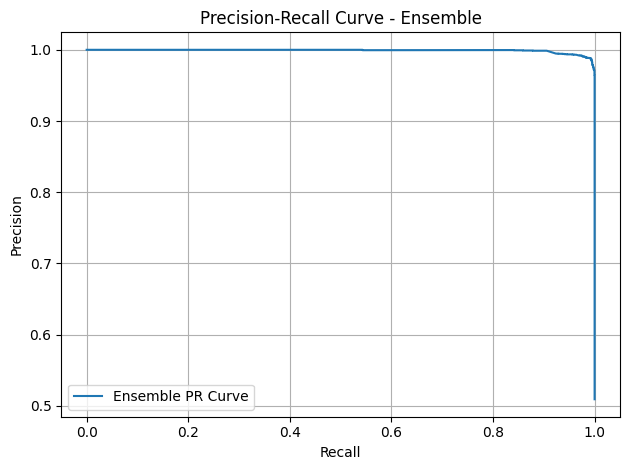


Total runtime: 204.28 seconds (3 minutes 24.28 seconds)
Achieved F1 (Ensemble) = 0.99. Target met


In [6]:
start_time = time.time()


# === Reproducibility: fix random seeds ===
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Basic cleaning
df['Message'] = (
    df['Message']
    .astype(str)
    .str.lower()
    .apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
)
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})

X = df['Message'].values
y = df['Spam/Ham'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Tokenization and padding for CNN branch ===
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_len)

# === CNN feature extractor model ===
cnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Helpers: timing and size reporting ===
def time_fit_keras(model, X, y, **fit_kwargs):
    t0 = time.time()
    history = model.fit(X, y, **fit_kwargs)
    ms = (time.time() - t0) * 1000
    return history, ms

def time_fit_sklearn(model, X, y):
    t0 = time.time()
    model.fit(X, y)
    ms = (time.time() - t0) * 1000
    return model, ms

def measure_inference_time(model, X_test_data, model_type='sklearn'):
    t0 = time.time()
    if model_type == 'sklearn':
        _ = model.predict(X_test_data)
    elif model_type == 'keras':
        _ = model.predict(X_test_data, verbose=0)
    return (time.time() - t0) * 1000

def logreg_param_count(lr_model):
    return lr_model.coef_.size + lr_model.intercept_.size

def keras_param_count(model):
    return model.count_params()

def xgb_complexity(xgb_model):
    # Trees + depth proxy
    n_trees = xgb_model.get_booster().num_boosted_rounds()
    max_depth = xgb_model.get_params().get('max_depth', None)
    return f"trees={n_trees}, max_depth={max_depth}"

def lgb_complexity(lgb_model):
    n_trees = lgb_model.get_params().get('n_estimators', getattr(lgb_model, 'n_estimators', None))
    num_leaves = lgb_model.get_params().get('num_leaves', getattr(lgb_model, 'num_leaves', None))
    return f"trees={n_trees}, num_leaves={num_leaves}"

# === Train CNN ===
cnn_history, cnn_train_ms = time_fit_keras(
    cnn_model, X_train_seq, y_train,
    batch_size=32, epochs=5, validation_split=0.1, verbose=2
)
cnn_infer_ms = measure_inference_time(cnn_model, X_test_seq, 'keras')
cnn_total_params = keras_param_count(cnn_model)

# === Extract CNN features (output from GlobalMaxPooling1D layer) ===
feature_extractor = Model(inputs=cnn_model.layers[0].input, outputs=cnn_model.layers[4].output)
X_train_cnn_feat = feature_extractor.predict(X_train_seq, verbose=0)
X_test_cnn_feat  = feature_extractor.predict(X_test_seq,  verbose=0)

# === TF-IDF features with n-grams ===
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# === Logistic Regression on TF-IDF (timed) ===
lr = LogisticRegression(max_iter=1000, random_state=42)
lr, lr_train_ms = time_fit_sklearn(lr, X_train_tfidf, y_train)
lr_pred  = lr.predict(X_test_tfidf)
lr_proba = lr.predict_proba(X_test_tfidf)[:, 1]
lr_infer_ms = measure_inference_time(lr, X_test_tfidf, 'sklearn')
lr_params = logreg_param_count(lr)

# === Logistic Regression on CNN features (timed) ===
lr_cnn_only = LogisticRegression(max_iter=1000, random_state=42)
lr_cnn_only, lr_cnn_train_ms = time_fit_sklearn(lr_cnn_only, X_train_cnn_feat, y_train)
lr_cnn_pred  = lr_cnn_only.predict(X_test_cnn_feat)
lr_cnn_proba = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]
lr_cnn_infer_ms = measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn')
lr_cnn_params = logreg_param_count(lr_cnn_only)

# === XGBoost on TF-IDF (timed) ===
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model, xgb_train_ms = time_fit_sklearn(xgb_model, X_train_tfidf, y_train)
xgb_pred  = xgb_model.predict(X_test_tfidf)
xgb_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]
xgb_infer_ms = measure_inference_time(xgb_model, X_test_tfidf, 'sklearn')
xgb_size = xgb_complexity(xgb_model)

# === LightGBM on TF-IDF (timed) ===
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model, lgb_train_ms = time_fit_sklearn(lgb_model, X_train_tfidf, y_train)
lgb_pred  = lgb_model.predict(X_test_tfidf)
lgb_proba = lgb_model.predict_proba(X_test_tfidf)[:, 1]
lgb_infer_ms = measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
lgb_size = lgb_complexity(lgb_model)

# === Soft Voting Ensemble (XGB + LGB + CNN + LR) ===
ensemble_soft_no_rf_proba = (xgb_proba + lgb_proba + lr_cnn_proba + lr_proba) / 4

# Threshold
THRESH = 0.5
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > THRESH).astype(int)

# === ROC-AUC for all models ===
lr_auc       = roc_auc_score(y_test, lr_proba)
lr_cnn_auc   = roc_auc_score(y_test, lr_cnn_proba)
xgb_auc      = roc_auc_score(y_test, xgb_proba)
lgb_auc      = roc_auc_score(y_test, lgb_proba)
ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)

# === Metrics helper ===
def all_scores(y_true, y_pred):
    return (
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
    )

# === Calculate metrics for all models ===
models_results = []

# Logistic Regression (TF-IDF)
lr_acc, lr_prec, lr_rec, lr_f1 = all_scores(y_test, lr_pred)
models_results.append([
    'Logistic Regression (TF-IDF)',
    lr_acc, lr_prec, lr_rec, lr_f1, lr_auc,
    f"params={lr_params:,}",
    f"train_ms={lr_train_ms:.2f}, infer_ms={lr_infer_ms:.2f}"
])

# Logistic Regression (CNN features)
lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1 = all_scores(y_test, lr_cnn_pred)
models_results.append([
    'Logistic Regression (CNN-features)',
    lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc,
    f"params={lr_cnn_params:,}",
    f"train_ms={lr_cnn_train_ms:.2f}, infer_ms={lr_cnn_infer_ms:.2f}"
])

# XGBoost
xgb_acc, xgb_prec, xgb_rec, xgb_f1 = all_scores(y_test, xgb_pred)
models_results.append([
    'XGBoost (TF-IDF)',
    xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc,
    xgb_size,  # complexity proxy
    f"train_ms={xgb_train_ms:.2f}, infer_ms={xgb_infer_ms:.2f}"
])

# LightGBM
lgb_acc, lgb_prec, lgb_rec, lgb_f1 = all_scores(y_test, lgb_pred)
models_results.append([
    'LightGBM (TF-IDF)',
    lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_auc,
    lgb_size,  # complexity proxy
    f"train_ms={lgb_train_ms:.2f}, infer_ms={lgb_infer_ms:.2f}"
])

# CNN (as a classifier itself at THRESH)
# We can also report the CNN's own metrics if you want:
cnn_proba = cnn_model.predict(X_test_seq, verbose=0).ravel()
cnn_pred  = (cnn_proba > THRESH).astype(int)
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = all_scores(y_test, cnn_pred)
cnn_auc = roc_auc_score(y_test, cnn_proba)
models_results.append([
    'CNN (Keras)',
    cnn_acc, cnn_prec, cnn_rec, cnn_f1, cnn_auc,
    f"params={cnn_total_params:,}",
    f"train_ms={cnn_train_ms:.2f}, infer_ms={cnn_infer_ms:.2f}"
])

# Ensemble
ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1 = all_scores(y_test, ensemble_soft_no_rf_pred)
ensemble_infer_ms = measure_inference_time(lr, X_test_tfidf, 'sklearn') \
                    + measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn') \
                    + measure_inference_time(xgb_model, X_test_tfidf, 'sklearn') \
                    + measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
ensemble_train_ms = lr_train_ms + lr_cnn_train_ms + xgb_train_ms + lgb_train_ms + cnn_train_ms  # if you want to include CNN pretraining cost

models_results.append([
    'Ensemble (XGB+LGB+CNN+LR)',
    ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc,
    "combined (see rows)",
    f"train_ms≈{ensemble_train_ms:.2f}, infer_ms≈{ensemble_infer_ms:.2f}"
])

# Print Result
headers = ["Model", "Acc", "Prec", "Rec", "F1", "AUC", "Size/Params", "Inference (ms)"]

rows = [
    ["Logistic Regression (TF-IDF)",        lr_acc,     lr_prec,     lr_rec,     lr_f1,     lr_auc,     f"params={lr_params:,}",              f"{lr_infer_ms:.2f}"],
    ["Logistic Regression (CNN-features)",  lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc, f"params={lr_cnn_params:,}",          f"{lr_cnn_infer_ms:.2f}"],
    ["XGBoost (TF-IDF)",                    xgb_acc,    xgb_prec,    xgb_rec,    xgb_f1,    xgb_auc,    xgb_size,                              f"{xgb_infer_ms:.2f}"],
    ["LightGBM (TF-IDF)",                   lgb_acc,    lgb_prec,    lgb_rec,    lgb_f1,    lgb_auc,    lgb_size,                              f"{lgb_infer_ms:.2f}"],
    ["CNN (Keras)",                         cnn_acc,    cnn_prec,    cnn_rec,    cnn_f1,    cnn_auc,    f"params={cnn_total_params:,}",        f"{cnn_infer_ms:.2f}"],
    ["Ensemble (XGB+LGB+CNN+LR)",           ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc,
                                            "combined (see rows)",                                           f"{(lr_infer_ms + lr_cnn_infer_ms + xgb_infer_ms + lgb_infer_ms):.2f}"],
]

print("\nMODEL EVALUATION TABLE (THRESH=0.5): Accuracy, Precision, Recall, F1, ROC-AUC, Params/Size, Inference time (ms)")
print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".3f"))

print("\nNotes:")
print("• Tree models: report structural complexity (trees/depth/leaves) instead of parameter count.")
print("• Keras/LogReg: report true parameter counts.")


# === Visuals for the Ensemble ===
ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
plt.title('Confusion Matrix - Ensemble')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble'); plt.legend(loc='lower right'); plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(recall, precision, label='Ensemble PR Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble'); plt.legend(loc='lower left'); plt.grid(True)
plt.tight_layout(); plt.show()

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

target_f1 = 0.98
print(f"Achieved F1 (Ensemble) = {ensemble_f1:.2f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")


